# (U-Th)/He data reduction notebook for the HAL at UIUC

## Introduction

This notebook was written by William Guenthner in fall of 2022 for the reduction of grain size data, U, Th, Sm, and He measurements towards calculation of (U-Th)/He dates. Some of the inputs and file formats are specific to data generated in the Helium Analysis Laboratory (HAL) at the University of Illinois Urbana-Champaign (UIUC), but hopefully it has broader applicability and utilty for other lab groups. 

The notebook is structured to interact with 3 separate CSV files that should be colocated with each instance of the notebook in the same folder. The CSV files are related to: 1) U, Th, Sm, Zr, and Ca amount measurements obtained from ICP-MS anlaysis (obtained with an iCAP Q using Qtegra software at UIUC), 2) He amount measurements (obtained with a PrismaPlus 220 and reported as peak hops on masses 1-5 at UIUC), and 3) grain size measurements for Ft correction. Cells are grouped below roughly in that order of reduction (wet chemistry first, then He, then grain size).

In [2]:
#packages to import and constants
import csv
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from scipy import special
%matplotlib inline

Avogadro = 6.022045e23 #atom/mol
ideal_gas_moles = 22.414 #liter/mol

#all in amu
mass_233U = 233.0396280 
mass_234U = 234.0409456
mass_235U = 235.0439231
mass_236U = 236.0455619
mass_238U = 238.0507826
mass_U = 238.028913

mass_229Th = 229.031754
mass_230Th = 230.033127
mass_232Th = 232.0380504
mass_Th = 232.0380504

mass_144Sm = 143.911995
mass_147Sm = 146.914893
mass_148Sm = 147.914818
mass_149Sm = 148.917180
mass_150Sm = 149.917271
mass_152Sm = 151.919728
mass_154Sm = 153.922205
mass_Sm = 150.366344

mass_40Ca = 39.96259
mass_42Ca = 41.95862
mass_43Ca = 42.95877
mass_44Ca = 43.95548
mass_46Ca = 45.95369
mass_48Ca = 47.95243
mass_Ca = 40.08601

mass_90Zr = 89.90470
mass_91Zr = 90.90564
mass_92Zr = 91.90504
mass_94Zr = 93.90631
mass_96Zr = 95.90828
mass_Zr = 91.22365

#all in 1/yr
lambda_238 = 1.55125e-10
lambda_235 = 9.84850e-10
lambda_232 = 4.9475e-11
lambda_147 = 6.54e-12

#chemistry constants specific to HAL
#mL
Vnm_UTh = 0.025
Vnm_UTh_d = Vnm_UTh * 0.01
Vnm_Sm = 0.025
Vnm_Sm_d = Vnm_Sm * 0.01
#ng/mL
concnm_U = 25.3458
concnm_U_d = 0.0181
concnm_Th = 49.8397
concnm_Th_d = 0.0284
concnm_Sm = 50.0797
concnm_Sm_d = 0.0284

## U, Th, Sm, Zr, and Ca reduction

At UIUC, we measure ratios of $^{238}$U/$^{236}$U, $^{232}$Th/$^{230}$Th, $^{236}$U/$^{238}$U, $^{152}$Sm/$^{149}$Sm, $^{90}$Zr/$^{91}$Zr, and $^{40}$Ca/$^{42}$Ca. The notebook is therefore designed around those specific ratios. It is also designed for the particular output format and column headers reported by an iCAP Q ICP-MS running the Qtegra software

First, we open our Qtegra CSV file and extract the relevant ratios. The U_Th_file needs to be updated with the appropriate name used for the iCAP run.

In [3]:
#fill in name of csv file here, make sure you're in the same directory as the notebook
U_Th_file = 'test.csv'

#function to extract relevant columns from csv file
def get_csv_data(file_name, type_string, title_string):
    
    with open(file_name, 'r') as in_file:
        csv_reader_UTh = csv.reader(in_file)
    
        #get type of columns (Raw.Average, Raw.Ratio.STD, etc) and title (238/236 (KED), etc.)
        run_type = next(csv_reader_UTh) 
        next(csv_reader_UTh) #throw away empty row
        run_title = next(csv_reader_UTh)
        next(csv_reader_UTh) #throw away this row too
        
        col_num = 0
        while col_num < len(run_type) and (run_type[col_num] != type_string or run_title[col_num] != title_string):
            col_num = col_num + 1
        if col_num == len(run_type):
            print('Error: column type or title not found')
        else:
             list_col = [0 if line[col_num]=='N/A' or line[col_num]=='' else float(line[col_num]) for line in csv_reader_UTh]
                
        return list_col

#extract relevant columns from csv file
list_149intensity = get_csv_data(U_Th_file, 'Raw.Average', '149Sm (KED)')
list_152intensity = get_csv_data(U_Th_file, 'Raw.Average', '152Sm (KED)')
list_230intensity = get_csv_data(U_Th_file, 'Raw.Average', '230Th (KED)')
list_232intensity = get_csv_data(U_Th_file, 'Raw.Average', '232Th (KED)')
list_236intensity = get_csv_data(U_Th_file, 'Raw.Average', '236U (KED)')
list_236intensity = get_csv_data(U_Th_file, 'Raw.Average', '236U (KED)')
list_238intensity = get_csv_data(U_Th_file, 'Raw.Average', '238U (KED)')
list_238_236 = get_csv_data(U_Th_file, 'Raw.Ratio.Average', '238U (KED) / 236U (KED)')
list_238_236_1s = get_csv_data(U_Th_file, 'Raw.Ratio.STD', '238U (KED) / 236U (KED)')
list_232_230 = get_csv_data(U_Th_file, 'Raw.Ratio.Average', '232Th (KED) / 230Th (KED)')
list_232_230_1s = get_csv_data(U_Th_file, 'Raw.Ratio.STD', '232Th (KED) / 230Th (KED)')
list_152_149 = get_csv_data(U_Th_file, 'Raw.Ratio.Average', '152Sm (KED) / 149Sm (KED)')
list_152_149_1s = get_csv_data(U_Th_file, 'Raw.Ratio.STD', '152Sm (KED) / 149Sm (KED)')
list_144_152 = get_csv_data(U_Th_file, 'Raw.Ratio.Average', '144Sm (KED) / 152Sm (KED)')
list_144_152_1s = get_csv_data(U_Th_file, 'Raw.Ratio.STD', '144Sm (KED) / 152Sm (KED)')
list_147_152 = get_csv_data(U_Th_file, 'Raw.Ratio.Average', '147Sm (KED) / 152Sm (KED)')
list_147_152_1s = get_csv_data(U_Th_file, 'Raw.Ratio.STD', '147Sm (KED) / 152Sm (KED)')
list_148_152 = get_csv_data(U_Th_file, 'Raw.Ratio.Average', '148Sm (KED) / 152Sm (KED)')
list_148_152_1s = get_csv_data(U_Th_file, 'Raw.Ratio.STD', '148Sm (KED) / 152Sm (KED)')
list_150_152 = get_csv_data(U_Th_file, 'Raw.Ratio.Average', '150Sm (KED) / 152Sm (KED)')
list_150_152_1s = get_csv_data(U_Th_file, 'Raw.Ratio.STD', '150Sm (KED) / 152Sm (KED)')
list_154_152 = get_csv_data(U_Th_file, 'Raw.Ratio.Average', '154Sm (KED) / 152Sm (KED)')
list_154_152_1s = get_csv_data(U_Th_file, 'Raw.Ratio.STD', '154Sm (KED) / 152Sm (KED)')


#extract sample names from csv file
with open(U_Th_file, 'r') as in_file:
    col_num = 1
    csv_reader_UTh = csv.reader(in_file)
    for i in range (4):
        next(csv_reader_UTh) #throw away the junk rows
    sample_list = [str(line[col_num]) for line in csv_reader_UTh]

#construct the data frame
U_Th_dict = {'149 intensity':list_149intensity,'152 intensity':list_152intensity,'230 intensity':list_230intensity,
             '232 intensity':list_232intensity,'236 intensity':list_236intensity,'238 intensity':list_238intensity,
             '238/236':list_238_236,'238/236 1s':list_238_236_1s, '232/230':list_232_230, '232/230 1s':list_232_230_1s, 
             '152/149':list_152_149, '152/149 1s':list_152_149_1s,'144/152':list_144_152,'144/152 1s':list_144_152_1s,
             '147/152':list_147_152,'147/152 1s':list_147_152_1s,'148/152':list_148_152,'148/152 1s':list_148_152_1s,
             '150/152':list_150_152,'150/152 1s':list_150_152_1s,'154/152':list_154_152,'154/152 1s':list_154_152_1s}

U_Th_data = pd.DataFrame(U_Th_dict, columns = ['149 intensity','152 intensity','230 intensity', '232 intensity', '236 intensity', 
                                      '238 intensity', '238/236','238/236 1s', '232/230', '232/230 1s', '152/149', 
                                      '152/149 1s','144/152','144/152 1s','147/152','147/152 1s','148/152',
                                      '148/152 1s','150/152','150/152 1s','154/152','154/152 1s'], index = sample_list)

We want to check blank intensities and spike normal ratio consistency throughout the run before moving on. The next couple of cells do just that.

In [4]:
#report out the blanks values for 152, 232, and 238
for i in range(0, len(sample_list)):
    if 'AB' in sample_list[i]:
        print('Blank levels for acid blank ',sample_list[i], ' are:\n',list_152intensity[i], ' for 152Sm, ',list_232intensity[i],' for 232Th, and ',list_238intensity[i],' for 238U\n')
    elif 'BB ' in sample_list[i]:
        print('Blank levels for bomb blank ',sample_list[i],' are:\n',list_152intensity[i],' for 152Sm, ',list_232intensity[i],' for 232Th, and ',list_238intensity[i],' for 238U\n')
    elif 'Empty' in sample_list[i]:
        print('Blank levels for Nb blank ',sample_list[i],' are:\n',list_152intensity[i],' for 152Sm, ',list_232intensity[i],' for 232Th, and ',list_238intensity[i],' for 238U\n')

Blank levels for acid blank  AB1  are:
 0.9897774696499638  for 152Sm,  21.600041920130565  for 232Th, and  9.200010880014336  for 238U

Blank levels for acid blank  AB2  are:
 0.7795533392976235  for 152Sm,  19.800029280063363  for 232Th, and  9.000009760012674  for 238U

Blank levels for acid blank  AB3  are:
 1.1872217170622306  for 152Sm,  20.800032960060932  for 232Th, and  14.400020800037634  for 238U

Blank levels for bomb blank  BB The Dude  are:
 8.359116590433722  for 152Sm,  66.20022608091712  for 232Th, and  33.00007152018394  for 238U

Blank levels for Nb blank  EmptyNb  are:
 4.7028804171313805  for 152Sm,  6155.7224433848105  for 232Th, and  111.00059280362923  for 238U

Blank levels for bomb blank  BB Maude  are:
 5.31310486748321  for 152Sm,  65.0002216008795  for 232Th, and  33.4000772802418  for 238U

Blank levels for bomb blank  BB Walter  are:
 2.7591079504178495  for 152Sm,  55.4001665605892  for 232Th, and  31.60006912019072  for 238U

Blank levels for bomb blank

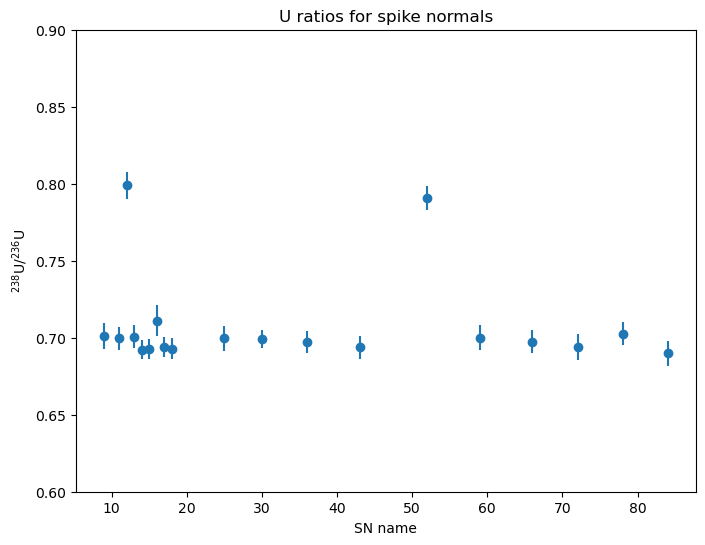

In [5]:
#plot spike normal ratios throughout the run to check for consistency
#this one plots
plt.figure(figsize = (8, 6))
plt.xlabel('SN name')
plt.ylabel('$^{238}$U/$^{236}$U')
plt.ylim(0.6, 0.9)
plt.title('U ratios for spike normals')

x_vals = []
y_vals = []
y_err = []
for i in range(0, len(sample_list)):
    if sample_list[i].startswith('SN'):
        x_vals.append(i)
        y_vals.append(float(list_238_236[i]))
        y_err.append(float(list_238_236_1s[i]))
plt.errorbar(x_vals, y_vals, y_err, fmt='o')
plt.show()

The next cell below calculates the U, Th, Sm, Zr, and Ca in our samples and saves the data in lists for the final report.